# Predicting Semiconductor Manufacturing Failures with Dense and Recurrent Neural Networks

In the previous two projects, after initial data exploration and preparation, I employed a number of machine learning techniques to predict semiconductor manufacturing failures. The following techniques were utilized:
* Logistic Regression
* Decision Tree
* Gradient Boosted Decision Tree
* Support Vector Classification

In the initial project, I generated a data flow diagram to detail the necessary steps to predict the manufacturing outcome and identify the most important features of a semiconductor manufacturing process (Figure 1). After doing some intial exploratory data analysis, it became clear that manufacturing failures are not as frequent as manufacturing successes. To overcome this, I used SMOTE to resample the training dataset and provide more failures to ensure a robust training model would be fit to the test dataset.

In this project, I continue to build on my earlier work. The data flow diagram, exploratory data analysis, data preparation, and SMOTE resampling were retained for context. From there I employed a few different deep learning techniques such as Dense and Recurrent Neural Networks to determine the most optimal model to predict semiconductor manufacturing failures.

__Figure 1. Data Flow Diagram detailing the process of predicting semiconductor manufacturing from obtaining the manufacturing data to predicting the manufacturing outcome.__
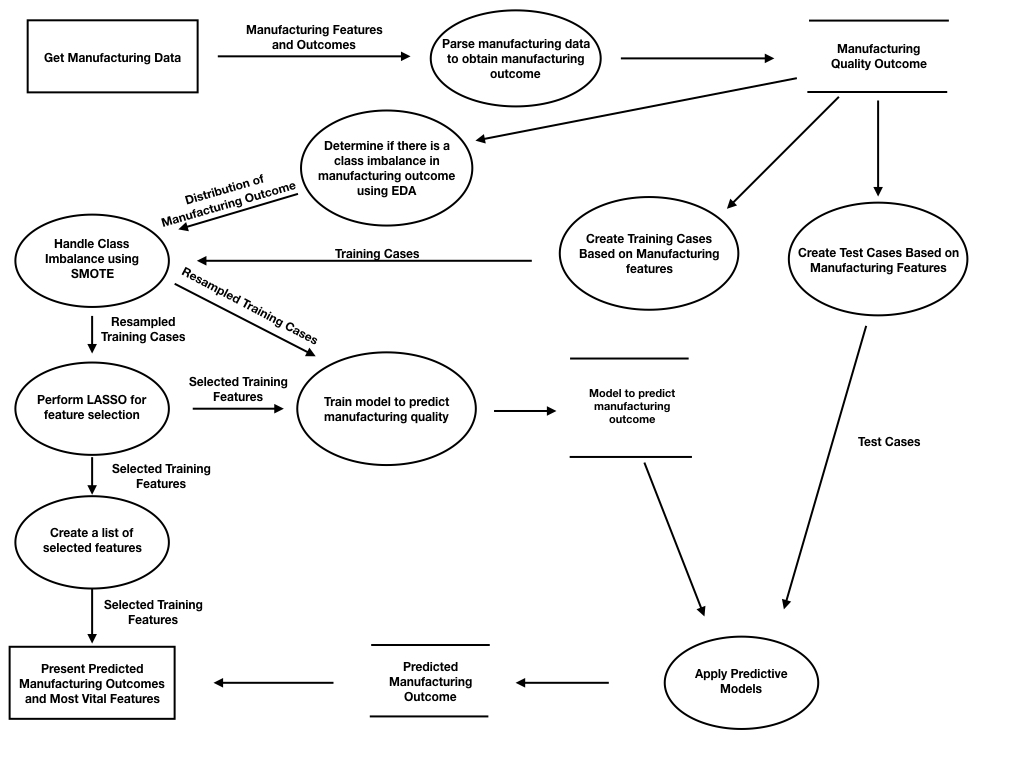


# Import data
The data must be imported along with the labels of each column. For now I've just named the features: feature1, feature2, and so on. These data were merged with the classification column (that holds the manufacturing outcome) and the date. All NA values were set to NaN for future imputation.

In [1]:
# import semiconductor manufacturing features and label data
import pandas as pd
import numpy as np
url_vars = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
names = ["feature" + str(x) for x in range(1, 591)] # name each feature sequentially
semi_vars = pd.read_csv(url_vars, sep=" ", names=names, na_values = "NaN")  # read in data, set column names, and set NAs to NaNs
 
url_labs = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
semi_labs = pd.read_csv(url_labs,sep=" ",names = ["classification","date"],parse_dates = ["date"],na_values = "NaN") # read in data, set column names, and set NAs to NaNs


In [2]:
# merge data and take a look at the first 5 rows
semi = pd.merge(semi_vars, semi_labs,left_index=True,right_index=True)
semi.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,classification,date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00


# Clean the dataset
After taking a look at the first 5 rows, we can see that the data have been merged properly and get an idea of how the dataset is structured. There are a steps we can take right away to clean up the dataset a bit. I started by imputing the NaNs within each feature with the median of the respective feature. Furthermore, I edited the classification column to be more straightforward by changing the name of the column to outcome and setting the successful manufacturing outcomes as 0 and the failures as a 1.

In [3]:
# replace missing values with the median of the column
semi.fillna(semi.median(), inplace=True)
# rename the classification column to outcome in order to be more representative of manufacturing outcome
semi.rename(columns={'classification': 'outcome'}, inplace = True)
# map the values of the outcome column to more interpretable 0 for success and 1 for failure
semi['outcome'] = semi['outcome'].map({-1: 0, 1: 1})


# Exploratory data analysis

Since the dataset describes the features that contribute to whether a semiconductor is successfully manufactured or not, I first wanted to see how the outcome was distributed. There is certainly a class imbalance within the manufacturing outcomes of this dataset with only about 100 failures out of over 1500 outcomes. This will be taken care of later on with SMOTE. 


To get a general sense of the features in the dataset, I obtained the summary statistics and started to dig into a few features that seemed to have an interesting summary statistics. I plotted this histograms of a few features, feature 4 and 590 appear to be have a distribution that is skewed to the right and feature 6 appears to be made up of only one value for all runs. This is interesting to note because it will most likely be removed later since it is a constant that probably doesn't affect the manufacturing outcome.


I also plotted the manufacturing outcome as a time series to determine if there was a specific time where there was any clustering of the failures around specific time frames. There are so many rows of data it's a bit hard to parse through but there does seem to be quite a few failures in August and September of 2008.

In [4]:
from matplotlib import pyplot as plt

# plot a histogram of the manufacturing success
plt.hist(semi['outcome'])
plt.title('Distribution of Manufacturing Success and Failures')
plt.ylabel('Count')
plt.xlabel('Manufacturing Outcome')
plt.show()


<Figure size 640x480 with 1 Axes>

In [5]:
# get the exact number of manufacturing success and failures
semi['outcome'].value_counts()

0    1463
1     104
Name: outcome, dtype: int64

In [6]:
# get the summary statistics for the entire dataset
semi.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,outcome
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3014.441551,2495.866110,2200.551958,1395.383474,4.171281,100.0,101.116476,0.121825,1.462860,-0.000842,...,82.403069,0.500096,0.015317,0.003846,3.067628,0.021458,0.016474,0.005283,99.652345,0.066369
std,73.480841,80.228143,29.380973,439.837330,56.103721,0.0,6.209385,0.008936,0.073849,0.015107,...,56.348694,0.003403,0.017174,0.003719,3.576899,0.012354,0.008805,0.002866,93.864558,0.249005
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,0.000000
25%,2966.665000,2452.885000,2181.099950,1083.885800,1.017700,100.0,97.937800,0.121100,1.411250,-0.010800,...,72.288900,0.497900,0.011600,0.003100,2.306500,0.013450,0.010600,0.003300,44.368600,0.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,0.000000
75%,3056.540000,2538.745000,2218.055500,1590.169900,1.518800,100.0,104.530000,0.123800,1.516850,0.008400,...,72.288900,0.502350,0.016500,0.004100,3.294950,0.027600,0.020300,0.006400,114.749700,0.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


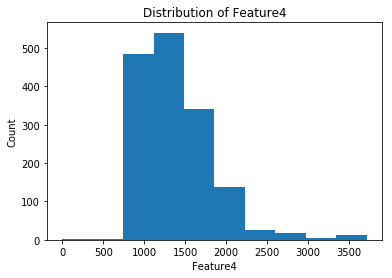

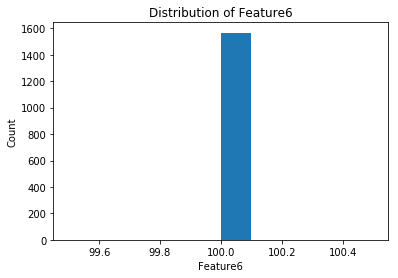

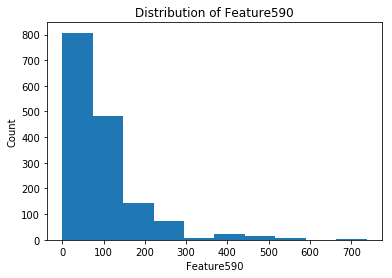

In [7]:
# plot a histogram of the distributions of a few features
# distribution of feature4
plt.hist(semi.feature4)
plt.title('Distribution of Feature4')
plt.ylabel('Count')
plt.xlabel('Feature4')
plt.show()

# distribution of feature6
plt.hist(semi.feature6)
plt.title('Distribution of Feature6')
plt.ylabel('Count')
plt.xlabel('Feature6')
plt.show()

# distribution of feature590
plt.hist(semi.feature590)
plt.title('Distribution of Feature590')
plt.ylabel('Count')
plt.xlabel('Feature590')
plt.show()



In [8]:
# set the date column to be in the datetime format for time series analysis
semi.loc[:, 'date'] = pd.to_datetime(semi.loc[:, 'date'])
semi.set_index('date', inplace = True) # set index on dataset
print(semi.head()) # print the beginning of the manufacturing dates
print(semi.tail()) # print the end of the manufacturing dates

                     feature1  feature2   feature3   feature4  feature5  \
date                                                                      
2008-07-19 11:55:00   3030.93   2564.00  2187.7333  1411.1265    1.3602   
2008-07-19 12:32:00   3095.78   2465.14  2230.4222  1463.6606    0.8294   
2008-07-19 13:17:00   2932.61   2559.94  2186.4111  1698.0172    1.5102   
2008-07-19 14:43:00   2988.72   2479.90  2199.0333   909.7926    1.3204   
2008-07-19 15:22:00   3032.24   2502.87  2233.3667  1326.5200    1.5334   

                     feature6  feature7  feature8  feature9  feature10  ...  \
date                                                                    ...   
2008-07-19 11:55:00     100.0   97.6133    0.1242    1.5005     0.0162  ...   
2008-07-19 12:32:00     100.0  102.3433    0.1247    1.4966    -0.0005  ...   
2008-07-19 13:17:00     100.0   95.4878    0.1241    1.4436     0.0041  ...   
2008-07-19 14:43:00     100.0  104.2367    0.1217    1.4882    -0.0124  ...   


Text(0.5, 1.0, 'Time series of Manufacturing Outcome')

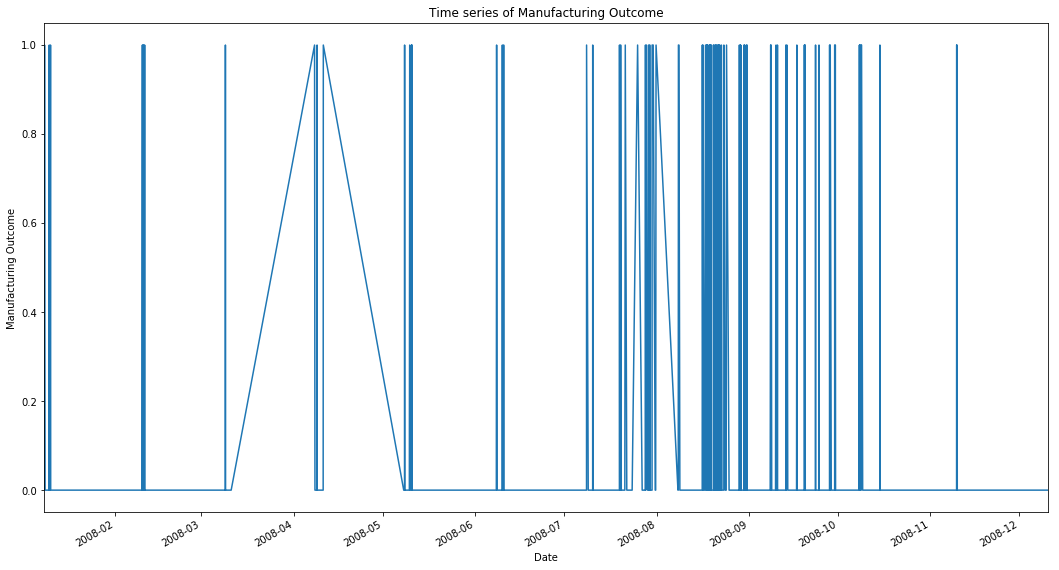

In [9]:
# plot the manufacturing outcome as a time series
ax = plt.figure(figsize=(18, 10)).gca() # define plot
semi.outcome.plot(ax = ax) # plot manufacturing outcome
ax.set_xlabel('Date')
ax.set_ylabel('Manufacturing Outcome')
ax.set_title('Time series of Manufacturing Outcome')

# Prepare the data for modeling
After cleaning and getting to know the dataset a bit more, I now need to start preparing the dataset for modeling. First, I identify the outcome column as the target we are trying to predict and determine that the features will be made up of the rest of the columns in the dataset. 

Next, the dataset is split up into training and test datasets further subsetted by their features and targets. The test dataset is made up of 20% of the original dataset.

In [10]:
# establish target and features of the manufacturing data
# set the target to the encoded manufacturing outcome column
target = semi[['outcome']]
# set the features as the rest of the dataset after dropping the features that are not necessary
feats = semi.drop(['outcome'], axis=1)


In [11]:
from sklearn import model_selection

# split original data into training and test sets
feat_train, feat_test , target_train, target_test = model_selection.train_test_split(feats, target, 
                                                    test_size=0.2, random_state=6)


# SMOTE

I use the SMOTE method to resample the training dataset and increase the number of failures within the dataset. This allows the model to train on more data that can help predict failures better. Because we used SMOTE, the modeling we perform will be a bit more representative of predicting manufacturing failures. 

In [12]:
import imblearn
from imblearn.over_sampling import SMOTE
# handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(feat_train, target_train)

/Users/caseythayer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Simple Neural Network Model

To predict semiconductor manufacturing failures, I built a simple neural network model. A neural network is made up of an input layer, a hidden layer, and an output layer. The input layer is made up of the features from the dataset and these are fed into the hidden layer. In this case the simple model I built contains only one hidden layer and I utilized the relu activation function. The output layer has 2 units such that the a binary classification of either a manufacturing failure or success is returned when training the model. I trained the model with 5 epochs and evaluated the accuracy by applying the trained model to the test data. An accuracy of around 90% is very good for a simple neural network model. It's possible that adding more hidden layers may result in overfitting. I will next build a dense neural network model to determine if more layers do a better job of predicting manufacturing failures.


In [13]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# build simple neural network
model = keras.Sequential([
    keras.layers.Flatten(), # flatten the input layer
    keras.layers.Dense(10, activation=tf.nn.relu), # hidden layer
    keras.layers.Dense(2, activation=tf.nn.relu) # output layer with two units
])

# compile the simple neural network model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train simple neural network model on the resampled training data with 5 epochs
model.fit(X_res, y_res, epochs=5)

# evaluate the model with the test data
test_loss, test_acc = model.evaluate(feat_test, target_test)

# print the accuracy
print('Test accuracy: ', test_acc)

/Users/caseythayer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/5
2338/2338 [==============================] - 0s 88us/sample - loss: 4.8323 - acc: 0.5038
Epoch 2/5
2338/2338 [==============================] - 0s 33us/sample - loss: 6.3217 - acc: 0.5000
Epoch 3/5
2338/2338 [==============================] - 0s 33us/sample - loss: 7.8717 - acc: 0.4987
Epoch 4/5
2338/2338 [==============================] - 0s 49us/sample - loss: 7.8717 - acc: 0.4987
Epoch 5/5
314/314 [==============================] - 0s 197us/sample - loss: 1.6200 - acc: 0.8981
Test accuracy:  0.8980892


# Dense Neural Network (DNN)

The dense neural network (DNN) that I built contains 5 hidden dense layers between the input and output layers. I increased the number of units in each hidden layer and employed mostly relu activation functions and two sigmoid activation functions. Once the model is trained and applied to the test data, the accuracy is about 1% which is very bad. It's interesting to see that the accuracy on the training data is higher, around 50% accurate. It looks like the in this case, adding additional layers resulted in overfitting.


In [14]:
# build the dense neural network
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(200, activation=tf.nn.sigmoid),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

# compile the DNN
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train the DNN with the resampled training data with 5 epochs
model.fit(X_res, y_res, epochs=5)

# evaluate the DNN by applying to the test data
test_loss, test_acc = model.evaluate(feat_test, target_test)

# print the accuracy
print('Test accuracy: ', test_acc)

Epoch 1/5
2338/2338 [==============================] - 0s 181us/sample - loss: 0.6958 - acc: 0.5128
Epoch 2/5
2338/2338 [==============================] - 0s 86us/sample - loss: 0.6944 - acc: 0.5090
Epoch 3/5
2338/2338 [==============================] - 0s 75us/sample - loss: 0.6940 - acc: 0.4914
Epoch 4/5
2338/2338 [==============================] - 0s 75us/sample - loss: 0.6929 - acc: 0.5201
Epoch 5/5
314/314 [==============================] - 0s 207us/sample - loss: 0.7186 - acc: 0.0637
Test accuracy:  0.06369427


# Recurrent Neural Network (RNN)

Recurrent Neural Networks (RNN) operate differently than the simple neural network and DNN by ingesting it's own outputs as inputs. RNNs are often referred to as having "memory" because of this feature and sequential information is preserved making it a great option for building predictive models with time series data.

In order to build an RNN with the semiconductor manufacturing data and predict failures, the training and test features had to be reshaped to be fed into the RNN input layer. The Long Short Term Memory (LSTM) layer helps to preserve the error that is backpropagated through layers and time. This layer also helps the model learn over longer time steps. In this case, I build an RNN with an input layer, one LSTM layer, one dense hidden layer, and an output layer. This model performs decently, with about 60% accuracy on the test dataset. The RNN does not perform as well as the simple neural network but better than the DNN, it may be more useful if we were trying to determine when manufacturing failures would occur given a specific range of time or a question that requires the sequences of the data to be conserved throughout analysis.

In [15]:
# reshape the resampled training features to feed into RNN
X_res = X_res.reshape((X_res.shape[0], 1, X_res.shape[1]))

# convert test features from a dataframe to an array
feat_test = feat_test.as_matrix()

# reshape the test features to feed into RNN
feat_test = feat_test.reshape((feat_test.shape[0], 1, feat_test.shape[1]))


/Users/caseythayer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [16]:
# build RNN model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(128, input_shape=(X_res.shape[1], X_res.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(4))
model.add(keras.layers.Dense(1, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# compile RNN model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print RNN model summary table
print(model.summary())

# train RNN
model.fit(X_res, y_res, validation_data=(feat_test, target_test), epochs=3, batch_size=64)

# evaluate the RNN by applying the trained model to the test data
scores = model.evaluate(feat_test, target_test, verbose=0)

# print the accuracy
print("Test Accuracy: ", scores[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 128)            92032     
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 2128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2         
Total params: 94,167
Trainable params: 94,167
Non-trainable params: 0
_________________________________________________________________
None
Train on 2338 samples, validate on 314 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
2338/2338 [==============================] - 1s 552us/sample - loss: 0.6913 - acc: 0.4880 - val_loss: 0.7157 - val_acc: 0.6943
Epoch 2/3
2338/2338 [============

# Conclusion

In the previous two projects, I've performed a number of analyses and built many different models for predicting semiconductor manufacturing failures. I started by creating a data flow diagram that details the necessary steps to predict the manufacturing outcome. Next, I did some exploratory data analysis, where I found that there are very few manufacturing failures compared to successes. I used SMOTE to resample the training dataset and provide more failures to train on. I then applied the following machine learning techniques:

* Logistic Regression
* Decision Tree
* Gradient Boosted Decision Tree
* Support Vector Classification

This project focused on leveraging deep learning to predict semiconductor manufacturing failures. I maintained much of the work I did previously (data flow diagram, importing data, exploratory data analysis, resampling the training data with SMOTE, etc) for clarity and consistency sake. I took the resampled training data and built three different neural networks. 

The simple neural network contained an input layer, a hidden layer, and an output layer. The model performed well with an accuracy of about 90% on the test data. This model is the most accurate and it's fairly simple to build. However, it's difficult to extrapolate specific process steps that may be leading to failures when applying a neural network because it's considered a "black box". The weights and biases are updated and feed forward through the network to end up with an output of a predicted manufacturing outcome. 

The dense neural network (DNN) included additional dense hidden layers with larger units within each one. I employed the relu activation function for most of the layers and the sigmoid activation function for the last two layers. I was curious to see if adding more layers resulted in overfitting but the DNN performed very poorly, with around 1% accuracy on the test dataset. It seems like adding more dense layers resulted in overfitting since the accuracy on the training dataset was a higher (around 50%).

The recurrent neural network (RNN) is different than the other two models because it includes a Long Short Term Memory (LSTM) layer that preserves the error backpropagated through time and layers. The RNN allows for the model to handle sequential and time series data. I built an RNN with an input layer, a LSTM layer, a dense hidden layer, and an output layer. The model performed decently with an accuracy of about 60%. This model doesn't seem to fit our question quite as well as the other models I've built. The dataset does have time series data that could be fed into an RNN if we were looking to answer a question that was more dependent on sequential manufacturing data or by the timing of semiconductor manufacturing failures. 

Final conclusions
* The simple neural network performed the best (about 90% accurate).
* The RNN does not seem extremely necessary for predicting the semiconductor manufacturing outcome and the model performs decently (about 60% accurate). 
* These deep learning models are useful in dealing with high dimensional data with many features. However, they are known as "black boxes" and do not provide many benefits in terms of feature engineering and finding the key process steps that may be leading to the failures. 
* It seems as though the feature engineering performed in my previous projects would be a more useful starting point for optimizing the manufacturing process but as more semiconductors are manufactured and the data continues to grow, the neural networks would be useful to track the failures within the manufacturing facility. 
* Would recommend the manufacturer focus on optimizing the features that emerged in the last project and then continuing to track the manufacturing performance with the simple neural network because it's able to learn throughout many different interactions with highly dimensional data and is fairly simple to build.